# Other datasets

To also include additional files within the object store including footprints, emissions [+boundary conditions+] you can do this by accessing the underlying methods and reading in the file.

At the moment, the expected format for these files is created through standard methods from within the acrg repository.

Before starting we need to define where our object store is loacted.

In [1]:
import os

#object_store = "/work/chxmr/objectStore" # Doesn't work with this for some reason?
object_store = "/work/rt17603/object_store"
os.environ["OPENGHG_PATH"] = object_store

### Observations

See [workflow.ipynb](workflow.ipynb#2.-Processing-data) tutorial notebook for how to add observation files to the object store, as well as how to access and use this data. For this example we need to make sure observations from the Tacolneston (TAC) site as part of the DECC network are within the Object store.

In [2]:
site="tac" 
network="DECC"
height="100m"
domain="EUROPE"
species="co2"

In [3]:
from openghg.modules import ObsSurface
import glob

obs_files = glob.glob("../data/DECC/tac*.dat")

ObsSurface.read_file(filepath=obs_files, data_type="CRDS", network="DECC",
                    overwrite=True)

Processing: tac.picarro.1minute.100m.test.dat: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]


defaultdict(dict,
            {'processed': {'tac.picarro.1minute.100m.min.dat': {'tac.picarro.1minute.100m.min_ch4': '14611268-89b3-4814-ab6d-af92d496b96b',
               'tac.picarro.1minute.100m.min_co2': '09623d13-ac23-4095-89c7-2c798e68f539'},
              'tac.picarro.1minute.100m.test.dat': {'tac.picarro.1minute.100m.test_ch4': '914baa1f-4568-4cc6-9969-a264702d8d7f',
               'tac.picarro.1minute.100m.test_co2': '33a1ebf2-a09e-453d-bf9d-f798c16c276e'}}})

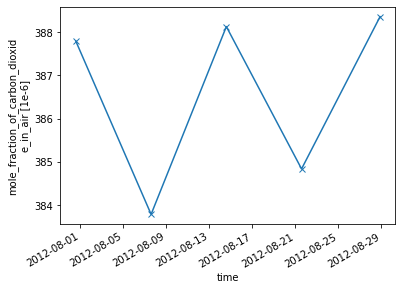

In [4]:
import matplotlib.pyplot as plt
from openghg.localclient import get_observations

start_date = "2012-08-01"
end_date = "2012-09-01"

obs = get_observations(site=site, species=species, start_date=start_date,
                        end_date=end_date, inlet=height, network=network)

mf = obs[0].data["mf"]
mf.plot(marker="x")

### Footprints

In [5]:
from openghg.modules._footprints import FOOTPRINTS

fp_file_path = "../data/footprints/TAC-100magl_EUROPE_201208.nc"

site="tac" 
network="DECC"
height="100m"
domain="EUROPE"
model_params={} # no details to add yet
overwrite=True

FOOTPRINTS.read_file(fp_file_path, site, network, height,
                    domain, model_params=model_params,
                    overwrite=overwrite)

{'TAC-100magl_EUROPE_201208.nc': '674db6c3-aa17-4981-a5ce-b5c53fca0391'}

### Emissions

In [6]:
from openghg.modules._emissions import Emissions

flux_file_path = "../data/emissions/co2-ff-edgar-bp-mth_EUROPE_2012.nc"

species="co2"
domain="EUROPE"
source="co2-ff-edgar-bp-mth"
high_time_resolution=False #???
overwrite=True

Emissions.read_file(flux_file_path, species, domain, source, 
                   high_time_resolution,
                   overwrite=overwrite)

{'co2-ff-edgar-bp-mth_EUROPE_2012.nc': 'f6f691f6-8382-4587-aa99-4475ddabe137'}

### Footprints data merge



In [7]:
from openghg.processing._process_footprint import footprints_data_merge

start_date = "2012-08-01"
end_date = "2012-09-01"

CombinedData = \
    footprints_data_merge(site, height, network, domain, 
                          start_date, end_date, species=species,
                          load_flux=True)
    
data = CombinedData.data
print(data)

<xarray.Dataset>
Dimensions:                    (height: 20, lat: 293, lev: 1, lon: 391, time: 4)
Coordinates:
  * time                       (time) datetime64[ns] 2012-08-07T14:50:30 ... ...
  * lon                        (lon) float32 -97.9 -97.55 -97.2 ... 39.03 39.38
  * lat                        (lat) float32 10.73 10.96 11.2 ... 78.82 79.06
  * lev                        (lev) object 'From     0 -    40m agl'
  * height                     (height) float32 500.0 1.5e+03 ... 1.95e+04
Data variables: (12/15)
    mf                         (time) float64 383.8 388.1 384.8 388.4
    mf_variability             (time) float64 0.209 0.061 0.064 0.208
    mf_number_of_observations  (time) float64 20.0 20.0 20.0 20.0
    fp                         (lat, lon, time) float32 0.0 0.0 0.0 ... 0.0 0.0
    temperature                (time) float32 15.73 17.13 20.44 15.96
    pressure                   (time) float32 992.7 1.001e+03 996.6 992.5
    ...                         ...
    release_lon

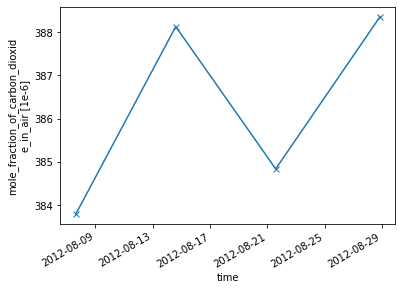

In [8]:
mf = data["mf"]
mf.plot(marker="x")
## Would want to be able to plot modelled mole fraction here as a comparison

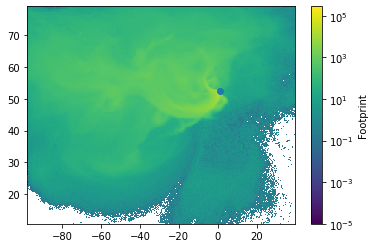

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## IDEALLY WOULD WANT TO LOAD CARTOPY HERE

fig, ax = plt.subplots()

## Plot footprints as a 2D colour map
data_fp = data["fp"].isel(time=0) # First time point
lat = data_fp.lat
lon = data_fp.lon
footprint = data_fp.values

vmin = 1e-5 # min is 0 and can't use 0 for a log scale
vmax = footprint.max()

im = ax.pcolormesh(lon, lat, footprint, 
              norm=colors.LogNorm(vmin=vmin, 
                                  vmax=vmax), shading="auto") # Put on a log scale
cb = plt.colorbar(im, ax=ax)
cb.set_label("Footprint")

## Add station position
station_lon = data.attrs["station_longitude"]
station_lat = data.attrs["station_latitude"]
ax.scatter([station_lon],[station_lat])